# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import time
import random
import numpy as np

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('A37_example_validate') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

In [3]:
# Set up base parameters of system.
ids = [5,11,14,16,24,29]

base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_validate'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': [3127.0,2736.0,2746.0,2448.0,4788.0,4565.0], # from Annex 37
    'battery_power_capacities': [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': [178.0,41.0,57.0,120.0,1349.0,257.0], # from Annex 37
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
# Set up probabilistic model of effiencies and take draws
n_draws = 10 #1000
mu = 0.9
sigma = 0.05
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))

In [5]:
#num_scenarios = [1,2,3,5,8,10,15,20]
num_scenarios = [1,2]
runtimes = {}

for M in num_scenarios:
    print(f"# Scenarios: {M}")

    etas = eta_samples[:M] # get M samples

    for m in range(M):
        # Build schema.
        base_kwargs.update({
                'battery_efficiencies': etas[m]
            })
        schema_path = build_schema(**base_kwargs)

        # Initialise CityLearn environment object.
        env = CityLearnEnv(schema=schema_path)

        if m == 0: # initialise lp object
            lp = LinProgModel(env=env)
        else:
            lp.add_env(env=env)

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='b',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    runtimes.update({M: end-start})
    print(f"Solve time: {round(runtimes[M],1)}s")

# Scenarios: 1
Solve time: 127.1s
# Scenarios: 2
Solve time: 572.1s


In [6]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.17066677 4.84465419]


In [7]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

42.355414659912135


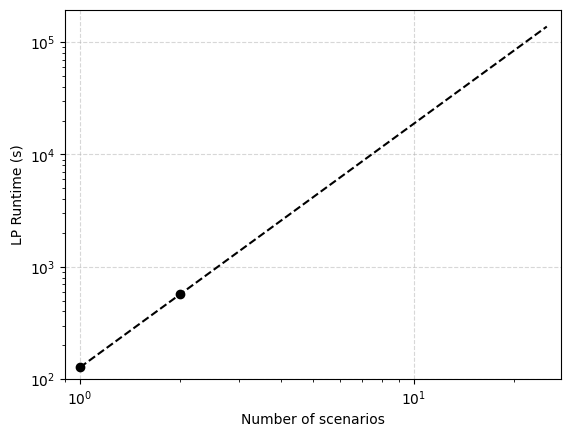

In [8]:
# Plot computational time results
max_scenarios = 25

plt.plot(runtimes.keys(),runtimes.values(),'ok')
plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--')
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Runtime (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(100)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()

In [9]:
# Compute MC estimate of true system cost

base_kwargs.update({ # set system to best scenario optimised design (latest)
    'battery_energy_capacities': lp_results['battery_capacities'],
    'pv_power_capacities': lp_results['solar_capacities']
})

cost_evals = []

# TODO: add multiprocessing to speed up
# add tqdm supress flag, use disable=True kwarg
# need to build schemas programmatically and then clean up

for j in range(n_draws):

    etas = eta_samples[j]

    # Build schema.
    base_kwargs.update({
            'battery_efficiencies': etas
        })
    schema_path = build_schema(**base_kwargs)

    eval_results = evaluate_system(schema_path,pricing_dict,opex_factor)

    cost_evals.append(eval_results['objective'])

17600it [03:51, 76.11it/s]                           


Evaluation complete.


17600it [03:54, 75.08it/s]                           


Evaluation complete.


17600it [03:53, 75.49it/s]                           


Evaluation complete.


17600it [03:43, 78.57it/s]                           


Evaluation complete.


17600it [03:43, 78.72it/s]                           


Evaluation complete.


17600it [03:43, 78.62it/s]                           


Evaluation complete.


17600it [03:48, 77.08it/s]                           


Evaluation complete.


17600it [03:41, 79.35it/s]                           


Evaluation complete.


17600it [03:45, 77.96it/s]                           


Evaluation complete.


17600it [03:48, 77.19it/s]                           

Evaluation complete.


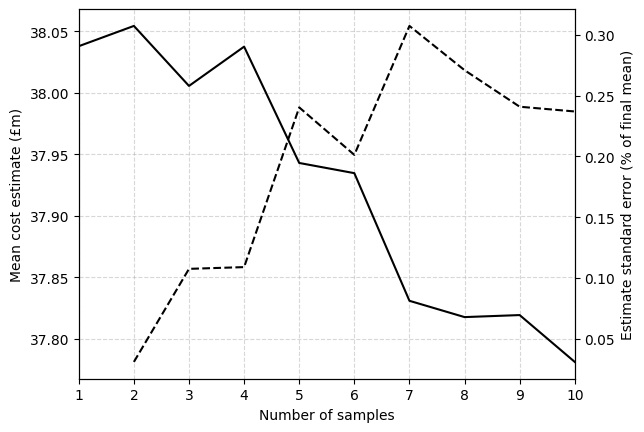

In [10]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

min_ax = ax.twinx()
min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
min_ax.set_ylabel('Estimate standard error (% of final mean)')
#min_ax.set_ylim(0)

plt.show()

In [11]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)

[38037857.63132935, 38070821.81609447, 37907954.794558644, 38133300.74463723, 37564502.58850685, 37893130.938586906, 37207936.71346836, 37724784.42153695, 37832320.636573784, 37438176.236054465]
[38037857.63132935, 38054339.72371191, 38005544.747327484, 38037483.74665492, 37942887.5150253, 37934594.75228557, 37830786.46102597, 37817536.20608984, 37819178.920588054, 37781078.6521347]
[11654.599291852315, 40591.483864301495, 41132.570121808, 90783.07198320264, 76030.37612680599, 116119.3112155421, 102357.59206013044, 90997.70710289378, 89519.49170970159]
